#BID3000 
#Task 2.B: Advanced Analytics Implementation 
# Python Analytics Integration 
#Olist E-commerce Analytics

#This notebook integrates with PostgreSQL (OlistDW), performs advanced analytics and exports the results for visalization in PowerBI
#Skriver på norsk her i tolkningene for det går mye raskere og jeg får formulert egne refleksjoner bedre. Kan skrive om til engelk i rapport

In [5]:
#Connect to postgres
import pandas as pd
from sqlalchemy import create_engine

# Database credentials 
user = "postgres"
password = "123"
host = "localhost"
port = "5432"
database = "OlistDW"

# engine
engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}")

# Test-tilkobling
test_df = pd.read_sql("SELECT * FROM fact_order_sales LIMIT 5;", engine)
test_df


,order_sales_key,order_id,order_item_id,product_key,date_key,seller_key,customer_key,shipping_limit_date,price,freight_value,total_item_value,quantity,profit_margin
0,1,00010242fe8c5a6d1ba2dd792cb16214,1,25386,20170913,514,50754,2017-09-19,58.90,13.29,72.19,1,45.61
1,2,00018f77f2f0320c557190d7a144bdd3,1,26728,20170426,472,88369,2017-05-03,239.90,19.93,259.83,1,219.97
2,3,000229ec398224ef6ca0657da4fc703e,1,22194,20180114,1825,21147,2018-01-18,199.00,17.87,216.87,1,181.13
3,4,00024acbcdf0a6daa1e931b038114c75,1,15109,20180808,2024,66033,2018-08-15,12.99,12.79,25.78,1,0.20
4,5,00042b26cf59d7ce69dfabb4e55b4fd9,1,8691,20170204,1598,37906,2017-02-13,199.90,18.14,218.04,1,181.76


,price,freight_value,quantity,product_category_name,customer_state
count,10000.000000,10000.000000,10000.0,10000,10000
unique,NaN,NaN,NaN,69,27
top,NaN,NaN,NaN,cama_mesa_banho,SP
freq,NaN,NaN,NaN,979,4237
mean,120.568763,20.141958,1.0,NaN,NaN
std,187.546617,16.434631,0.0,NaN,NaN
min,3.490000,0.000000,1.0,NaN,NaN
25%,39.900000,13.080000,1.0,NaN,NaN
50%,74.980000,16.320000,1.0,NaN,NaN
75%,136.917500,21.320000,1.0,NaN,NaN


product_category_name
cama_mesa_banho           979
beleza_saude              847
esporte_lazer             770
moveis_decoracao          757
informatica_acessorios    742
utilidades_domesticas     601
relogios_presentes        533
telefonia                 420
brinquedos                416
ferramentas_jardim        369
Name: count, dtype: int64
customer_state
SP    4237
RJ    1297
MG    1103
RS     559
PR     465
SC     377
BA     332
DF     229
GO     214
ES     197
PE     164
CE     143
PA     101
MT      84
MA      83
MS      74
RN      62
PI      58
PB      55
AL      37
RO      31
SE      29
TO      29
AM      16
AP      11
AC       8
RR       5
Name: count, dtype: int64
                  price  freight_value  quantity
price          1.000000       0.436208       NaN
freight_value  0.436208       1.000000       NaN
quantity            NaN            NaN       NaN


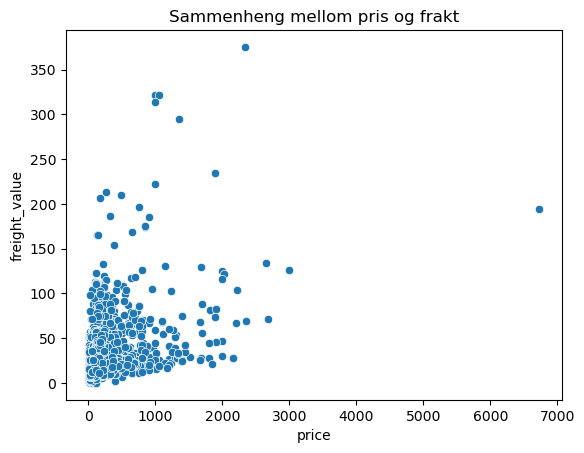

In [6]:
# Descriptive Analytics: Statistical summary and correlation analysis
import seaborn as sns
import matplotlib.pyplot as plt

#trekk ut sales + product + customer
query = """
SELECT f.price, f.freight_value, f.quantity,
       d.product_category_name, c.customer_state
FROM fact_order_sales f
JOIN dim_products d ON f.product_key = d.product_key
JOIN dim_customer c ON f.customer_key = c.customer_key
LIMIT 10000;
"""
sales = pd.read_sql(query, engine)

# Statistisk sammendrag
display(sales.describe(include="all"))

print(sales['product_category_name'].value_counts().head(10))
print(sales['customer_state'].value_counts())

# Korrelasjon (numeriske variabler)
corr_matrix = sales.corr(numeric_only=True)
print(corr_matrix)

sns.scatterplot(x='price', y='freight_value', data=sales)
plt.title("Sammenheng mellom pris og frakt")
plt.show()




### Tolkning av analysen
**Deskriptiv analyse**
- Prisene varierer fra 3,49 til 6.735 BRL?
- Median pris er 74, 98
- De fleste produktene er billige, men noen få dyre drar opp gjennomsnittet.
-Gjennomsnittlig fraktkostnad er 20, som er høyt sammenliknet med de typiske produktprisene
- Hele Brazil(27 deler) er representert
- Sao Paulo kundene står for over 40% av ordrene og er den viktigste regionen for e-handelen(4237 ordre)
- Det er 69 unike kategorier                        
- Den mest populære produktlategorien er cama-mesa_banho. (seng,bord,bad)

**Korrelasjonsanalyse**
- Det er en svak positiv korrelasjon (r = 0,44) mellom produktpris og fraktkostnad. Siden antall alltid er en på en ordrelinje gir det ingen korrelasjon med pris eller frakt. 
- Pris og frakt bør vurderes separat. Fokus på produkter med høy frakt i forhold til pris bør undersøkes og optimaliseres for å øke kundetilfredshet og sjansen for gjennkjøp.
- Nå kan vi lite om Brazil som marked, men det er et veldig stort land, så prisen på frakt kan naturlig nok bli høy. Dette er et område vert å undersøke for bedriften.


                        
                        

cluster
0    4429
1    4120
2    1451
Name: count, dtype: int64


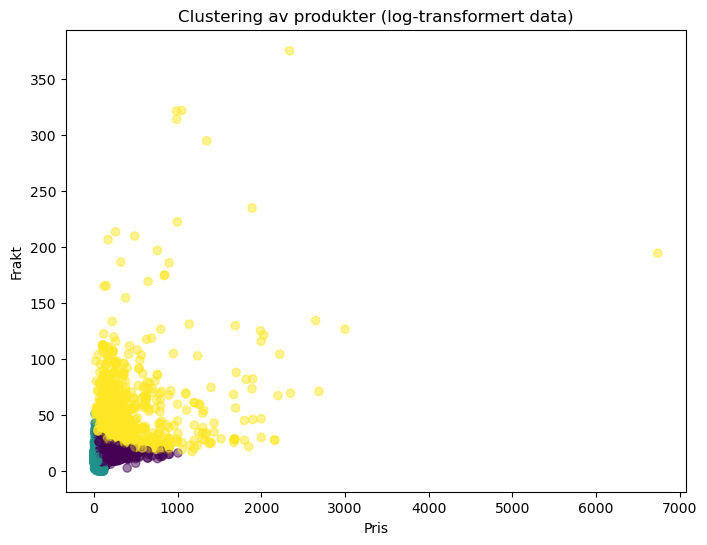

In [13]:
#Predictive Analytics med Clustering (KMeans)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Velg numeriske kolonner
data = sales[['price','freight_value']]

# Log-transformasjon for å håndtere skjev fordeling
data_log = np.log1p(data)  # log(1+x) for å unngå log(0)

# Skaler dataene
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_log)

# KMeans clustering med 3 cluster og flere init
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
sales['cluster'] = kmeans.fit_predict(data_scaled)

# Sjekk antall produkter per cluster
print(sales['cluster'].value_counts())

# Visualisering
plt.figure(figsize=(8,6))
plt.scatter(sales['price'], sales['freight_value'], c=sales['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel("Pris")
plt.ylabel("Frakt")
plt.title("Clustering av produkter (log-transformert data)")
plt.show()

# Descriptive + Predictive analytics
sales.to_csv("sales_analysis.csv", index=False)



# Tolkning av cluster-resultat
Cluster 0(4429 produkter) Produkter med lav til middels pris og frakt. Små, billige produkter med jevnt salg
Cluster 1 (4120 produkter) Produkter med middels pris og frakt, varer med moderat margin og volum
Cluster 2 (1451 produkter) Produkter med høy pris og høy frakt, dyre eller store varer.

Clusteringen skal hjelpe med å forstå produktfordeling og logistikkbehov.
Olist kan optimalisere lager, markedsføring og kampanjer basert på cluster.
Fokuser på cluster 2 for optimalisering, cluster 0 for volum salg.


           product_category_name                        product_id  \
0      agro_industria_e_comercio  11250b0d4b709fee92441c5f34122aed   
1      agro_industria_e_comercio  423a6644f0aa529e8828ff1f91003690   
2      agro_industria_e_comercio  672e757f331900b9deea127a2a7b79fd   
74                     alimentos  89321f94e35fc6d7903d36f74e351d40   
75                     alimentos  ed2067a9c1f79553088a3c67b99a9f97   
...                          ...                               ...   
29886             telefonia_fixa  b4f9530c931398e215242293c2c8ba4c   
29887             telefonia_fixa  4633dfeb3a2588bdb52af32d504b44eb   
30001      utilidades_domesticas  42a2c92a0979a949ca4ea89ec5c7b934   
30002      utilidades_domesticas  5a6e53c3b4e8684b13388d6aa4afdf12   
30003      utilidades_domesticas  f7a17d2c51d9df89a4f1711c4ac17f33   

       total_sales  
0               22  
1               18  
2               17  
74             119  
75              55  
...            ...  
29886       

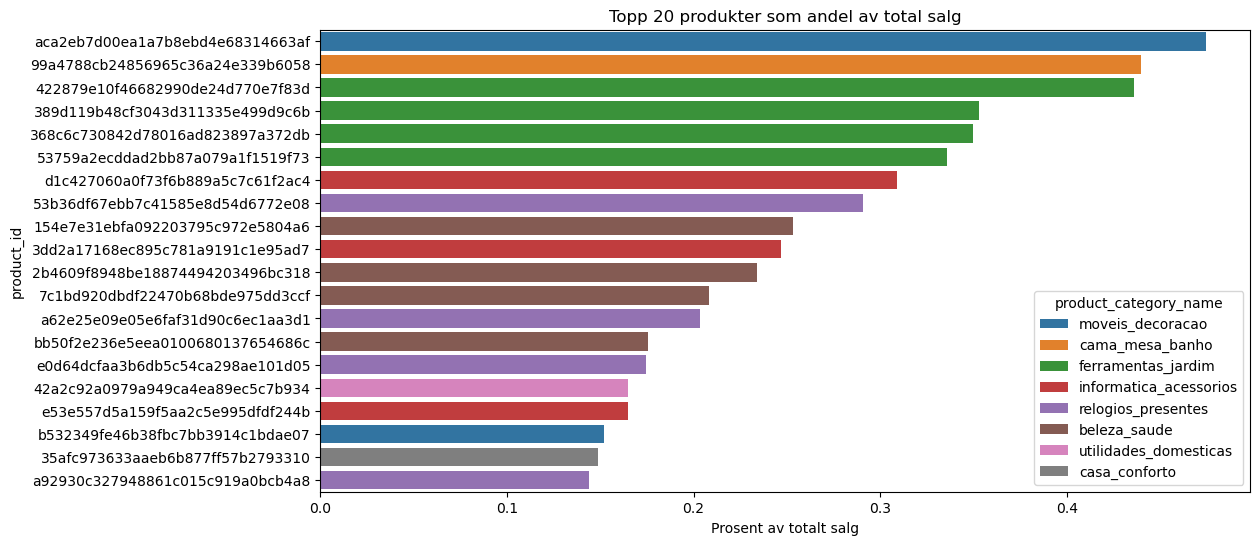

In [15]:
#Prescriptive Analytics: Optimization or recommendation algorithm

recommendation_query = """
SELECT d.product_category_name, d.product_id, COUNT(*) AS total_sales
FROM fact_order_sales f
JOIN dim_products d ON f.product_key = d.product_key
GROUP BY d.product_category_name, d.product_id
ORDER BY d.product_category_name, total_sales DESC;
"""
recs = pd.read_sql(recommendation_query, engine)

# Gi topp 3 anbefalinger per kategori
top_recs = recs.groupby("product_category_name").head(3)
print(top_recs)
# Beregn prosentandel av total salg
recs['sales_pct'] = recs['total_sales'] / recs['total_sales'].sum() * 100

# Topp 20 produkter etter prosentandel
top_products_pct = recs.sort_values('sales_pct', ascending=False).head(20)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(
    data=top_products_pct,
    x='sales_pct',
    y='product_id',
    hue='product_category_name',
    dodge=False
)
plt.title("Topp 20 produkter som andel av total salg")
plt.xlabel("Prosent av totalt salg")
plt.show()


top_products = recs.groupby(['product_category_name','product_id'])['total_sales'].sum().reset_index()
top_products['sales_pct'] = top_products['total_sales'] / top_products['total_sales'].sum() * 100

# Eksporter til CSV for Power BI
top_products.to_csv("top_products.csv", index=False)




# Tolkning
Produktene med høyest total_sales(183 og 119) er de mest populære
Siden disse selger bra bør det prioriteres å ha på lager og i markdsføring og kampanjer for å øke.
Produktene med lave salgstall(12-22) selger lite. De kan vurderes å trekke fra sortimentet eller inkluderes i kampanjer og markedsføring
Utilidaes_domesticas har noen av de mest solgte produktene og er en viktig kategori- Alimentos har også produkter med høyt salg.
Business anbefaling: Fokuser på top-sellers, kategorier og produkter med høyt salg, optimaliser lager og logistikk(Og tenk på frakt). Vurder tiltak på produkter med lavt slag.